In [12]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pylab as plt
import sys

#constants:
test_using_sklearn = True

def read_file(filename):
    data = []
    with open('%s'%filename) as file:
        content = csv.reader(file)
        for c in content:
            data.append(c)
    return np.matrix(data).astype(np.float32)

class boosted_linear_classifier(object):
    
    def __init__(self,Xtrain,ytrain,Xtest,ytest):
        self.n_train = Xtrain.shape[0]
        self.sample_weights = np.repeat(1/self.n_train,
                                        self.n_train).reshape(-1,1)
        self.Xtrain = Xtrain
        self.Xtest = Xtest
        self.ytrain = ytrain
        self.ytest = ytest

        #record running totals for the final prediction:
        self.total_pred_train_mag = 0
        self.total_pred_test_mag = 0

        #recording for charts later
        self.train_errors = []
        self.test_errors = []
        self.boost_eps = []
        self.boost_alphas = []
        self.num_sample_occurences = np.zeros(self.n_train)
        self.eps_upperbound_running_total = 0
        self.eps_upper_bound = []
        
    def new_boostrap_sample(self):
        # print(len(list(np.asarray(self.sample_weights).flatten())))
        # print(self.sample_weights.shape)
        # print(self.sample_weights.flatten().tolist())
        self.bt_sample_ind = np.random.choice(
                            self.n_train,self.n_train,
                            replace=True,
                            p=list(np.asarray(self.sample_weights).flatten())
                            )
        #update the sample occurence counts:
        for i in self.bt_sample_ind:
            self.num_sample_occurences[i]+=1

    def train(self):
        #Filter data as per the sample:
        X = self.Xtrain[self.bt_sample_ind,:]
        y = self.ytrain[self.bt_sample_ind]
        #Find weights :
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        # print(self.weights.shape)

    def predict(self):
        self.curr_predict_train = np.sign(self.Xtrain.dot(self.weights))
        self.curr_predict_test = np.sign(self.Xtest.dot(self.weights))

        #calculate eps:
        # print(sum(~np.equal(ytrain,self.curr_predict_train)))
        self.eps = np.sum(self.sample_weights[~np.equal(self.ytrain,
                                              self.curr_predict_train)])
        #check if eps is >0.5
        if self.eps>0.5:
            self.weights = -self.weights
            self.predict()

    
    def calc_alpha(self):

        self.alpha = 0.5*np.log((1-self.eps)/self.eps)
        
        self.boost_eps.append(self.eps)
        self.boost_alphas.append(self.alpha)
        #print(self.alpha)

        #update upper bound:
        self.eps_upperbound_running_total += (0.5-self.eps)**2
        self.eps_upper_bound.append(np.exp(-2*self.eps_upperbound_running_total))

    def calc_prediction_error(self):
        #update totals:
        self.total_pred_train_mag += self.alpha*self.curr_predict_train
        self.total_pred_test_mag += self.alpha*self.curr_predict_test
        
        #get errors:
        train_error = np.mean(np.sign(self.total_pred_train_mag)!=self.ytrain)
        test_error = np.mean(np.sign(self.total_pred_test_mag)!=self.ytest)

        #update the error list
        self.train_errors.append(train_error)
        self.test_errors.append(test_error)

    def update_sample_weights(self):
        mutiplier = np.exp(-self.alpha*np.multiply(self.ytrain,
                                                   self.curr_predict_train))
        # print(mutiplier)
        #scale:
        self.sample_weights = np.multiply(self.sample_weights,
                                          mutiplier)
        #normalize:
        # print(sum(self.sample_weights))
        self.sample_weights = self.sample_weights / sum(self.sample_weights)
        # print(self.sample_weights.shape)

def line_plot(x,y1,y2,xticks,xlabel,ylabel,title,savfigname,leg=None):
    plt.figure()
    plt.plot(x,y1,'b')

    if y2 is not None:
        plt.plot(x,y2,'g')
        plt.legend(leg)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(savfigname)
    plt.show()

def boosting(X_train,y_train,X_test,y_test):

    #Add dimension of 1s 
    X_train = np.column_stack((np.ones(X_train.shape[0]),X_train))
    X_test = np.column_stack((np.ones(X_test.shape[0]),X_test))

    T=1500
    n_train = X_train.shape[0]

    #create a class object:
    boosted_lc = boosted_linear_classifier(X_train,y_train,X_test,y_test)

    #start boosting:
    for t in range(T):
        # print(t)
        #take a new bootstrap sample:
        boosted_lc.new_boostrap_sample()

        #train the classifier:
        boosted_lc.train()
        boosted_lc.predict()

        #calculate alpha for that classifier:
        boosted_lc.calc_alpha()

        #calculate prediction error for classifier:
        boosted_lc.calc_prediction_error()

        #update sample weights:
        boosted_lc.update_sample_weights()

    #print stuff:
    line_plot(range(1,T+1),boosted_lc.train_errors,boosted_lc.test_errors,
              xticks=np.linspace(1,T,6),
              xlabel='Boosting Iteration',
              ylabel='Error',
              title='Train and Test Errors vs Boosting Iteration',
              savfigname='hw3_2a_train_test_error.png',
              leg=['train error','test error'])

    #plot upper bound on et:
    line_plot(range(1,T+1),boosted_lc.eps_upper_bound,None,
              xticks=np.linspace(1,T,6),
              xlabel='Boosting Iteration',
              ylabel='Upper Bound on Training Error',
              title='Upper Bound on Training Error vs Boosting Iteration',
              savfigname='hw3_2b_upper_bound_trainerror.png',)

    #plot number of occurences of each sample:
    plt.figure()
    plt.bar(range(1,n_train+1),boosted_lc.num_sample_occurences)
    plt.xlabel('Sample index')
    plt.ylabel('#Times Sampled')
    plt.title('Total Number of selections of training data points')
    plt.savefig('hw3_2c_sample_frequency.png')
    plt.show()

    #plot eps and alpha separately:
    line_plot(range(1,T+1),boosted_lc.boost_alphas,y2=None,
              xticks=np.linspace(1,T,6),
              xlabel='Boosting Iteration',
              ylabel='alpha',
              title='Alpha vs Boosting Iteration',
              savfigname='hw3_2d_alphas.png')
    line_plot(range(1,T+1),boosted_lc.boost_eps,y2=None,
              xticks=np.linspace(1,T,6),
              xlabel='Boosting Iteration',
              ylabel='eps',
              title='Eps vs Boosting Iteration',
              savfigname='hw3_2d_eps.png')

    



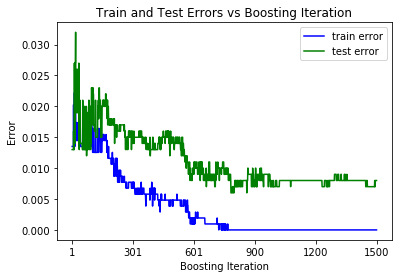

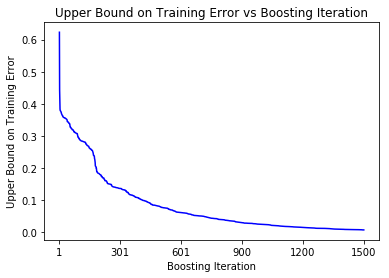

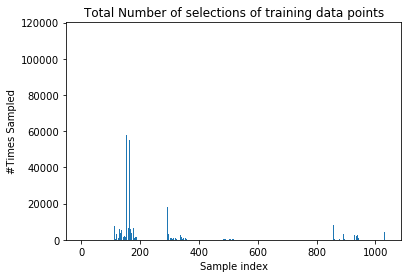

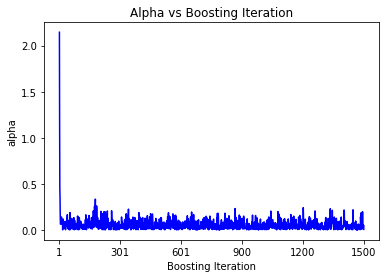

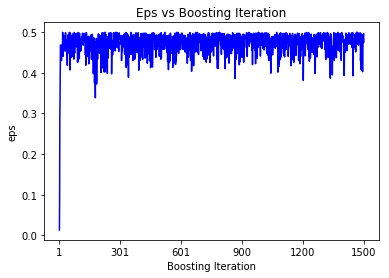

In [13]:
X_train = read_file('boosting/X_train.csv')
X_test = read_file('boosting/X_test.csv')
Y_train = read_file('boosting/y_train.csv')
Y_test = read_file('boosting/y_test.csv')
boosting(X_train,Y_train,X_test,Y_test)